In [1]:
libraries = c("dplyr", "magrittr", "tidyr", "surveillance", "rstan") 
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

'%&%' = function(x,y)paste0(x,y)

R.Version()$version.string

options(mc.cores = parallel::detectCores())

This is surveillance 1.18.0. For overview type 'help(surveillance)'.

Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')
although this causes Stan to throw an error on a few processors.



[1] "R version 4.0.0 Patched (2020-05-24 r78561)"

# Loading the dataset

In [2]:
datestar = as.Date("2020-05-10")
datemin = as.Date("2019-12-25") # particular choice

read.csv("../data/JapaneseDataCOVID19 ("%&%format(datestar,"%y%m%d")%&%").csv") %>%
    mutate(report = if_else(is.na(confirmed), reported, confirmed), 
           # report and onset as Dates
           report = as.Date(report), 
           onset = as.Date(onset),
           # time_report and time_onset as the number of days since datemin
           time_onset = as.numeric(onset - datemin),  
           time_report = as.numeric(report - datemin)) %>%
    # removing original column as no need anymore
    select(-confirmed, -reported) -> df

# nicer order ot the columns
df %<>% select(exp_type, is_asymptomatic, onset, time_onset, report, time_report)

# number of days between the cutoff time and datemin
(tstar = as.numeric(datestar - datemin))

df

[1] 137

exp_type,is_asymptomatic,onset,time_onset,report,time_report
<chr>,<int>,<date>,<dbl>,<date>,<dbl>
imported,0,2020-01-03,9,NA,NA
imported,0,2020-01-14,20,NA,NA
imported,0,2020-01-21,27,NA,NA
imported,0,2020-01-23,29,NA,NA
imported,0,2020-01-22,28,NA,NA
imported,0,2020-01-26,32,NA,NA
domestic,0,2020-01-14,20,NA,NA
domestic,0,2020-01-20,26,NA,NA
domestic,0,2020-01-23,29,NA,NA


In [3]:
# At the moment we have a line-list, but we also want to have the number of imported and domestic cases per day
# so we need to count and change the dataframe from long to wide format 
df %>%
    # respectively to the day of illness onset (time_onset)
    select(exp_type, time_onset) %>% 
    # to count the cases we group by exp_type (domestic vs imported) and by time_onset
    group_by(exp_type, time_onset) %>% 
    summarize(n = n()) %>%
    # then we transform the dataframe to the wide format
    spread(exp_type, n) %>% 
    # however some days are missing because there were no cases on those days (e.g. at the beginning of the outbreak)
    # so we account for all subsequent days from datemin to datestar
    right_join(expand_grid(time_onset = seq(from = 1, to = tstar-1, by = 1)), by='time_onset') %>% 
    # those missing days would have NAs, so we replace them with zeros
    replace(is.na(.), 0) %>%
    # for simplicity renaming the time columns
    rename(time = time_onset) -> Df_cases

Df_cases %>% tail

`summarise()` regrouping output by 'exp_type' (override with `.groups` argument)



time,domestic,imported
<dbl>,<int>,<int>
22,0,0
23,0,0
24,0,0
25,0,0
34,0,0
136,0,0


In [4]:
# because some cases do not have date of illness onset, we still want to count them and probably do the backprojection later
# so we repeat the previous procedure but by the day of report
df %>% 
    filter(is.na(time_onset)) %>% 
    select(exp_type, time_report) %>% 
    group_by(exp_type, time_report) %>% 
    summarize(n = n()) %>% 
    spread(exp_type, n) %>% 
    # we mark those cases with "_unobs"-postfix
    rename(imported_unobs = imported, 
           domestic_unobs = domestic, 
           time = time_report) %>% 
    # joining with the previously obtained dataframe
    right_join(Df_cases, by='time') %>% 
    # again some days have zero counts, so they will be NAs after the right_join => making them zeros
    replace(is.na(.), 0) %>%
    arrange(time) -> Df_cases

Df_cases %>% tail

`summarise()` regrouping output by 'exp_type' (override with `.groups` argument)



time,domestic_unobs,imported_unobs,domestic,imported
<dbl>,<int>,<int>,<int>,<int>
131,27,0,28,0
132,27,0,19,0
133,15,0,17,0
134,11,0,7,0
135,12,0,4,0
136,11,0,0,0


## <font color="purple">Backprojection</font>

In [5]:
# if the observed counts are close to the right end, the backprojection algorithm can be unstable for them 
# as outlined by the developer of the package
# so we will play a bit safer and put additional 10 days after datestar filled with zeros
df_cases = Df_cases %>% rbind(data.frame(time=seq(tstar,tstar+10,1), imported=0, imported_unobs=0, domestic=0, domestic_unobs=0))
df_cases %>% tail

time,domestic_unobs,imported_unobs,domestic,imported
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
142,0,0,0,0
143,0,0,0,0
144,0,0,0,0
145,0,0,0,0
146,0,0,0,0
147,0,0,0,0


In [6]:
K = nrow(df_cases)

# Incubation time period is adopted from [Linton et al 2020]
# other research groups give quite similar values of the mean 5.2 days
# see https://github.com/aakhmetz/COVID19IncubationPeriod
inc_fit = list(meanlog=1.519, sdlog=0.615)
incubation_probability = plnorm(1:K, inc_fit$meanlog, inc_fit$sdlog) - plnorm(1:K-1, inc_fit$meanlog, inc_fit$sdlog)
# the surveillance packages requires to keep zero at the beginning
inc_pmf = c(0,incubation_probability[1:41])
# smoothing parameter values for backprojection of imported and domestic
k_used = c(2,2)

# if the backprojected value falls below this threshold, we set it to zero 
# in this case we will avoid arbitrarily small values which make no sense
epsilon = 1e-3

# backprojection of imported cases
# parameters of the backprojection follows the parameters adopted in the tutorial for the package
# the backprojection is done only if there are imported cases in the database
if (sum(df_cases$imported)>0) {
    sts = new("sts", epoch=df_cases$time, observed=df_cases$imported)
    bpnp.control = list(k = k_used[1], eps = rep(1e-4,2), iter.max=rep(1000,2), 
                        B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    # output result
    df_cases['imported_backproj'] = upperbound(sts_bp) %>% as.numeric %>% replace(. < epsilon, 0) 
    df_cases['imported_backproj'] = df_cases['imported_backproj']/sum(df_cases['imported_backproj'])*sum(df_cases$imported)
} else 
    df_cases['imported_backproj'] = 0

## backprojection of domestic cases (=domesically acquired infections)
if (sum(df_cases$domestic)>0) {
    sts = new("sts", epoch=df_cases$time, observed=df_cases$domestic)
    bpnp.control = list(k = k_used[2], eps = rep(1e-4,2), iter.max=rep(1000,2), 
                        B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_cases['domestic_backproj'] = upperbound(sts_bp) %>% as.numeric %>% replace(. < epsilon, 0) 
    df_cases['domestic_backproj'] = df_cases['domestic_backproj']/sum(df_cases['domestic_backproj'])*sum(df_cases$domestic)
} else
    df_cases['domestic_backproj'] = 0

df_cases %>% tail(30)

time,domestic_unobs,imported_unobs,domestic,imported,imported_backproj,domestic_backproj
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
118,115,0,155,0,0,98.108752345
119,71,0,162,0,0,93.958232329
120,83,0,106,0,0,86.820185261
121,66,0,147,0,0,76.029308817
122,47,0,115,0,0,62.129701932
123,22,0,104,0,0,47.032092685
124,47,0,121,0,0,32.748434689
125,117,0,94,0,0,20.166454186
126,49,0,69,0,0,10.333683929


## <font color="purple">Backprojection including cases with unobserved date of illness onset</font>

In [7]:
# Backprojection of cases with unknown (=unobserved) dates of illness onset is done in two subsequent steps
# First we backproject to the suggesting date of illness onset
# Second we sum up with known observed counts and backproject them together by the incubation period
# This is done like that because the surveillance package actually prohibits the heterogeneity in the data

# Reporting delay: from onset to confirmation
# the values are obtained separetely and here it is assumed to be known
onset2report_fit = list(param1 = 1.741, param2 = 8.573)
onset2report_probability = pweibull(1:K, onset2report_fit$param1, scale=onset2report_fit$param2) - pweibull(1:K-1, onset2report_fit$param1, scale=onset2report_fit$param2)
onset2report_pmf = c(0,onset2report_probability[1:41])

## import
if (sum(df_cases$imported_unobs)>0) {
    sts = new("sts", epoch=df_cases$time, observed=df_cases$imported_unobs)
    bpnp.control = list(k = k_used[1], eps = rep(1e-4,2), iter.max=rep(1000,2), 
                        B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=onset2report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    # output result
    df_cases['imported_backproj_unobs'] = upperbound(sts_bp) %>% as.numeric %>% replace(. < epsilon, 0) 
    df_cases['imported_backproj_unobs'] = df_cases['imported_backproj_unobs']/sum(df_cases['imported_backproj_unobs'])*sum(df_cases$imported_unobs)
} else 
    df_cases['imported_backproj_unobs'] = 0

## secondary
if (sum(df_cases$domestic_unobs)>0) {
    sts = new("sts", epoch=df_cases$time, observed=df_cases$domestic_unobs)
    bpnp.control = list(k = k_used[2], eps = rep(1e-3,2), iter.max=rep(1000,2), 
                        Tmark = tstar - 1, #attention
                        B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("C"))
    sts_bp = backprojNP(sts, incu.pmf=onset2report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_cases['domestic_backproj_unobs'] = upperbound(sts_bp) %>% as.numeric %>% replace(. < epsilon, 0) 
    df_cases['domestic_backproj_unobs'] = df_cases['domestic_backproj_unobs']/sum(df_cases['domestic_backproj_unobs'])*sum(df_cases$domestic_unobs)
} else
    df_cases['domestic_backproj_unobs'] = 0
df_cases %<>% ungroup

df_cases %>% filter(time<tstar) %>% tail(20)

time,domestic_unobs,imported_unobs,domestic,imported,imported_backproj,domestic_backproj,imported_backproj_unobs,domestic_backproj_unobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
117,98,0,219,0,0,1.021782e+02,0,55.275342682
118,115,0,155,0,0,9.810875e+01,0,53.085239052
119,71,0,162,0,0,9.395823e+01,0,51.242101691
120,83,0,106,0,0,8.682019e+01,0,48.486515636
121,66,0,147,0,0,7.602931e+01,0,43.398273012
122,47,0,115,0,0,6.212970e+01,0,35.194230769
123,22,0,104,0,0,4.703209e+01,0,24.678663446
124,47,0,121,0,0,3.274843e+01,0,14.449643806
125,117,0,94,0,0,2.016645e+01,0,7.017536818


In [8]:
# Now backprojecting unobs + obs by the incubation period

# backprojection of imported_unobs cases
if (sum(df_cases$imported_unobs)>0) {
    sts = new("sts", epoch=df_cases$time, observed=df_cases$imported_backproj_unobs + df_cases$imported)
    bpnp.control = list(k = k_used[1], eps = rep(1e-4,2), iter.max=rep(1000,2), Tmark = nrow(df_cases)-10,
                        Tmark = tstar - 1, #attention
                        B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    # output result
    df_cases['imported_backproj_incl_unobs'] = upperbound(sts_bp) %>% as.numeric %>% replace(. < epsilon, 0) 
    df_cases['imported_backproj_incl_unobs'] = df_cases['imported_backproj_incl_unobs']/sum(df_cases['imported_backproj_incl_unobs'])*sum(df_cases$imported_backproj_unobs + df_cases$imported)
} else 
    df_cases['imported_backproj_incl_unobs'] = 0

# backprojection of domestic_unobs cases
if (sum(df_cases$domestic_unobs)>0) {
    sts = new("sts", epoch=df_cases$time, observed=df_cases$domestic_backproj_unobs + df_cases$domestic)
    bpnp.control = list(k = k_used[2], eps = rep(1e-4,2), iter.max=rep(1000,2), 
                        B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("C"))
    sts_bp = backprojNP(sts, incu.pmf=inc_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_cases['domestic_backproj_incl_unobs'] = upperbound(sts_bp) %>% as.numeric %>% replace(. < epsilon, 0) 
    df_cases['domestic_backproj_incl_unobs'] = df_cases['domestic_backproj_incl_unobs']/sum(df_cases['domestic_backproj_incl_unobs'])*sum(df_cases$domestic_backproj_unobs + df_cases$domestic)
} else
    df_cases['domestic_backproj_incl_unobs'] = 0

df_cases %>% filter(time<tstar) %>% tail(30)

time,domestic_unobs,imported_unobs,domestic,imported,imported_backproj,domestic_backproj,imported_backproj_unobs,domestic_backproj_unobs,imported_backproj_incl_unobs,domestic_backproj_incl_unobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
107,151,0,371,2,0.004898637,2.537108e+02,0.009760285,1.009866e+02,0.003141247,3.056866e+02
108,154,0,356,0,0.000000000,2.311702e+02,0.001660786,8.799885e+01,0.000000000,2.859795e+02
109,56,0,283,2,0.000000000,2.061040e+02,0.000000000,8.128916e+01,0.000000000,2.625939e+02
110,56,2,323,0,0.000000000,1.831526e+02,0.000000000,7.647833e+01,0.000000000,2.398983e+02
111,147,0,292,0,0.000000000,1.660050e+02,0.000000000,7.202435e+01,0.000000000,2.220498e+02
112,101,0,280,0,0.000000000,1.539337e+02,0.000000000,6.843435e+01,0.000000000,2.087914e+02
113,98,0,226,0,0.000000000,1.440922e+02,0.000000000,6.556801e+01,0.000000000,1.973702e+02
114,91,0,225,0,0.000000000,1.338058e+02,0.000000000,6.296449e+01,0.000000000,1.847542e+02
115,119,0,216,0,0.000000000,1.216966e+02,0.000000000,6.050123e+01,0.000000000,1.687925e+02


In [9]:
# total number of imported cases
sum(df_cases$imported) + sum(df_cases$imported_unobs)

[1] 342

In [10]:
# total number of domestically acquired infections
sum(df_cases$domestic) + sum(df_cases$domestic_unobs)

[1] 15062

In [11]:
# among them are unobsered
sum(df_cases$domestic_unobs)

[1] 2889

In [12]:
df_cases %<>% select(-domestic_backproj_unobs,-imported_backproj_unobs) %>% filter(time<tstar)
df_cases %>% write.csv("../results/JapaneseDataCOVID19_with_backproj ("%&%format(datestar,"%y%m%d")%&%").csv", row.names=FALSE)

# <font color="green">[R] Effective reproduction number</font>

## <font color="purple">Stan program</font>

In [13]:
## The code is written by Andrei R. Akhmetzhanov and verified by Kenji Mizumoto
"functions {
    /* discretesized version of lognormal distribution */
    // the first element is after day one 
    vector plognormal(real mu, real sigma, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | mu, sigma));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);        
    }

    /* discretesized version of Weibull distribution */
    vector pweibull(real kappa, real theta, int K) {
        vector[K] res; 
        for (k in 1:K) 
            res[k] = -expm1(-pow(1.0*k/theta, kappa)); // instead of using Stan function weibull_lcdf it is easier to write it directly

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* calculating the convolutions */
    // X: first function, Yrev: reversed version of the second function
    // K: length of X and Yrev
    // the result is the vector of length K-1, because the first element equal zero is omitted
    vector convolution(vector X, vector Yrev, int K) {
        vector[K-1] res;
        res[1] = X[1]*Yrev[K];
        for (k in 2:K-1) // 2:K-1 is equivalent to 2:(K-1)
            res[k] = dot_product(head(X, k), tail(Yrev, k)); // by definition of the convolution

        return res;        
    }

    /* Special form of the convolution with adjusting to the delay */
    // F: cumulative distribution function of the reporting delay
    // it is the same idea as in [Tsuzuki et al 2017] (doi:10.2807/1560-7917.ES.2017.22.46.17-00710)
    vector convolution_with_delay(vector X, vector Yrev, vector F, int K) {
        vector[K-1] res;
        vector[K] Z = X ./ F; // first we need to nowcast the observed counts (=to account for not yet reported)

        res[1] = F[2]*Z[1]*Yrev[K];
        for (k in 3:K) 
            res[k-1] = F[k]*dot_product(head(Z, k-1), tail(Yrev, k-1));

        return res;        
    }
}

data {
    int<lower = 1> K; //number of days
    vector<lower = 0>[K] imported_backproj;
    vector<lower = 0>[K] domestic_backproj;
    int<lower = K> upper_bound;

    // serial interval
    real<lower = 0> param1_SI;
    real<lower = 0> param2_SI;

    // reporting delay is given by Weibul distribution
    real<lower = 0> param1_delay;
    real<lower = 0> param2_delay;

    // incubation period
    real mu_inc;
    real<lower = 0> sigma_inc;
}

transformed data {
    // RStan requires to declare all variables at the beginning, so there is some mixture
    vector[K] cases_backproj;

    vector[K-1] conv;
    vector[K-1] conv_delay_adj;

    cases_backproj = imported_backproj + domestic_backproj;
    // all variables declared within {..} are local 
    // so they will not be recorded in the output of Stan
    {
        // serial interval
        vector[K] gt;
        vector[K] gtrev;
        // incubation period
        vector[upper_bound] IncPeriod; 
        vector[upper_bound] IncPeriod_inv;
        // reporting delay
        vector[upper_bound] ReportDelay;
        vector[upper_bound] conv_report_inc;
        
        vector[upper_bound] F_tmp;
        vector[K] F; 

        // serial interval is modeled by Weibull distribution
        gt = pweibull(param1_SI, param2_SI, K);
        for (k in 1:K) 
            gtrev[k] = gt[K+1-k];

        // incubation period is modeled by lognormal distribution
        IncPeriod = plognormal(mu_inc, sigma_inc, upper_bound);
        // we need to have it in reverse order for our convolution function used later
        for (k in 1:upper_bound)
            IncPeriod_inv[k] = IncPeriod[upper_bound+1-k];

        // reporting delay is modeled by Weibull distribution
        ReportDelay = pweibull(param1_delay, param2_delay, upper_bound);

        // convolution of the reporting delay and incubation period
        conv_report_inc = append_row(rep_vector(0,1), convolution(ReportDelay, IncPeriod_inv, upper_bound));
        conv_report_inc = cumulative_sum(conv_report_inc);
        
        // here the form is a bit complicated because technically upper_bound is not K in general, it can be any number > K
        for (k in 1:upper_bound) 
            F_tmp[k] = conv_report_inc[upper_bound+1-k];
        F = head(F_tmp, K);

        // convolution without adjusting for the delay
        conv = convolution(cases_backproj, gtrev, K);

        // convolution with adjusting for the delay
        conv_delay_adj = convolution_with_delay(cases_backproj, gtrev, F, K);
    }
}

parameters {
    // effective reproduction number without adjustment to the delay in reporting
    vector<lower = 0>[K-1] Rt;

    // effective reproduction number with adjustment to the delay in reporting
    vector<lower = 0>[K-1] Rt_adj;
}

model {
    Rt ~ normal(2.4, 2.0);
    Rt_adj ~ normal(2.4, 2.0);
    
    // two independent likelihood written in one line
    target += gamma_lpdf(tail(domestic_backproj, K-1) | Rt .* conv + 1e-13, 1.0)
            + gamma_lpdf(tail(domestic_backproj, K-1) | Rt_adj .* conv_delay_adj + 1e-13, 1.0);
}" %>% cat(file="fit_infection.stan", sep="", fill=TRUE)

In [14]:
#model discription
stanmodel = NULL
stanmodel = stan_model(file='fit_infection.stan')

## <font color="purple">Data</font>

In [15]:
stan_data = list(
  K = nrow(df_cases),
  imported_backproj = df_cases$imported_backproj,
  domestic_backproj = df_cases$domestic_backproj,
  upper_bound = tstar,
  ## Serial interval [Nishiura et al 2020 - only certain cases]
  param1_SI = 2.305,
  param2_SI = 5.452,
  ## reported delay
  param1_delay = onset2report_fit$param1,
  param2_delay = onset2report_fit$param2,
  ## incubation period [Linton et al 2020 - with right truncation excl. Wuhan residents]
  mu_inc = inc_fit$meanlog,
  sigma_inc = inc_fit$sdlog
  )

## <font color="purple">MCMC settings</font>

In [16]:
Iter =   10000
Warmup =  2000
Chains =    2
Seed =   1234

## <font color="purple">Model fit</font>

In [17]:
fit <- sampling(stanmodel, 
                data=stan_data,
                iter=Iter,
                warmup=Warmup,
                chains = Chains, 
                seed=1234)

In [18]:
require(tibble)
require(stringr)

# Check the result
## Rt is for backproj
## Rt_adj is for backproj_incl_unobs
## The first and the last values should be ignored because no information is available and Rt* is unstable
### notice that Reff starts from t=2 not t=1, so one of the coordinates is shifted by one
summary(fit)$summary %T>% 
    write.csv("../results/Results of Stan (script C).csv") %>%
    as.data.frame %>% tibble::rownames_to_column("index") -> df_summary

out = stringr::str_match_all(df_summary$index, "[\\d+(.*)]")
df_summary$time = sapply(out, function(x) paste(x[,1],collapse=""))
df_summary %<>% mutate(time = as.numeric(time) + 1, variable = str_extract(index, "^[^\\[]+")) %>%
    select(-index) %>% select(variable, time, everything())

df_summary %>% head

Loading required package: tibble

Loading required package: stringr



,variable,time,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Rt,2,3.803845,0.01137938,1.617343,0.9585255,2.615784,3.706837,4.886268,7.201542,20200.72,0.9999394
2,Rt,3,3.802308,0.01105958,1.614534,0.9787390,2.619588,3.705229,4.898468,7.190752,21311.65,0.9999047
3,Rt,4,3.827900,0.01124618,1.614151,0.9969482,2.646266,3.737979,4.883448,7.246082,20600.51,0.9999704
4,Rt,5,3.831425,0.01121714,1.616146,1.0311345,2.658927,3.725188,4.913039,7.230205,20758.55,0.9999470
5,Rt,6,3.847621,0.01095309,1.633813,0.9934183,2.661992,3.751999,4.920421,7.303961,22250.04,0.9999310
6,Rt,7,3.833713,0.01135992,1.623234,0.9947558,2.641717,3.723736,4.892645,7.255641,20417.93,0.9999616


In [19]:
df_summary %>%
    filter(variable=='Rt_adj') %>% 
    select(time,`2.5%`,`25%`,`50%`,`75%`,`97.5%`) -> df_summary_
names(df_summary_) = c('time','Rt_lower','Rt_IQR_lower','Rt_median','Rt_IQR_upper','Rt_upper')
df_summary_ %>% head

,time,Rt_lower,Rt_IQR_lower,Rt_median,Rt_IQR_upper,Rt_upper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.9606674,2.661039,3.735816,4.905539,7.243792
2,3,0.9695339,2.637299,3.716757,4.891109,7.245668
3,4,0.9545927,2.646601,3.737445,4.894425,7.228038
4,5,0.9811007,2.649600,3.756910,4.899631,7.293788
5,6,1.0486528,2.667259,3.752073,4.909372,7.228146
6,7,1.0087498,2.690629,3.757193,4.898231,7.266286


In [20]:
df_cases %>%
    mutate(date = datemin + time) %>% 
    left_join(df_summary_, by='time') %>%
    select(date,time,everything()) %>% na.omit -> figure_data

range = c(as.Date("2020-02-01"), datestar - 17)
figure_data %<>% filter(date < range[2], date > range[1])

figure_data %>% head

date,time,domestic_unobs,imported_unobs,domestic,imported,imported_backproj,domestic_backproj,imported_backproj_incl_unobs,domestic_backproj_incl_unobs,Rt_lower,Rt_IQR_lower,Rt_median,Rt_IQR_upper,Rt_upper
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-02-02,39,0,0,4,0,1.1739613,2.409345,1.1749413,2.728569,0.2426307,0.6056138,0.8556800,1.1559016,1.768350
2020-02-03,40,0,0,9,1,0.8989732,1.507233,0.9008537,2.270909,0.1165546,0.3413098,0.5030566,0.6928784,1.129236
2020-02-04,41,0,0,5,0,0.5000108,1.472679,0.5019078,3.032050,0.1035112,0.3041492,0.4552194,0.6290248,1.022204
2020-02-05,42,0,0,1,1,0.2010538,2.091894,0.2022331,4.879109,0.1479826,0.4044045,0.5753616,0.7828775,1.226896
2020-02-06,43,0,0,5,1,0.1082749,3.269345,0.1083783,7.486603,0.2899271,0.6441551,0.8832466,1.1554194,1.716245
2020-02-07,44,0,0,1,2,0.1967178,4.742397,0.1943830,9.907324,0.5015735,1.0310168,1.3605620,1.7081972,2.470284


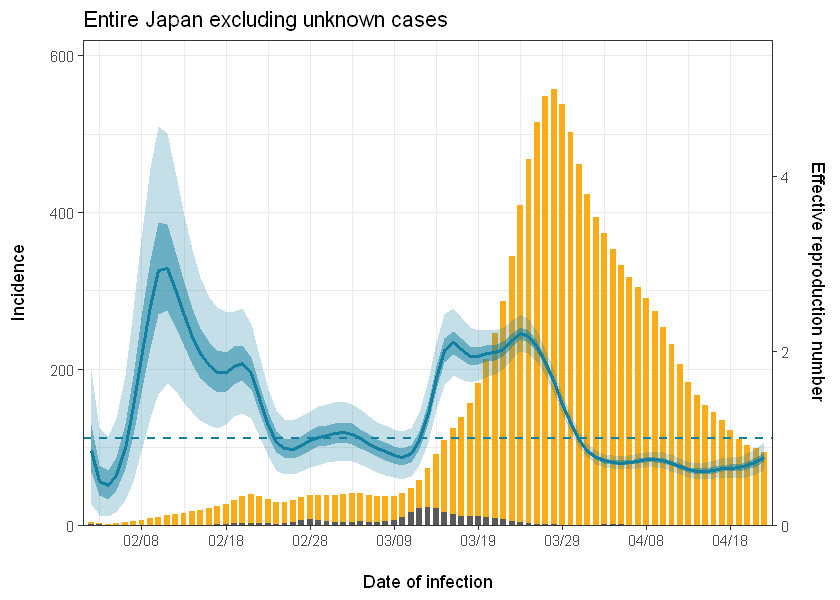

In [21]:
scaling_parameter=max(figure_data$domestic_backproj+figure_data$imported_backproj)/5.0
options(repr.plot.width=7,repr.plot.height=5)

figure_data %>% 
    select(date,imported_backproj,domestic_backproj) %>% 
    gather(exp_type,value,-date) %>%
    ggplot(aes(x=date)) + 
        geom_bar(aes(y=value, fill=exp_type, group=exp_type), stat='identity', width=0.7) +
        geom_line(data = figure_data, aes(y=Rt_median*scaling_parameter),color="#1380A1",size=1) +
        geom_ribbon(data = figure_data, 
                    aes(ymax=Rt_upper*scaling_parameter, ymin=Rt_lower*scaling_parameter), 
                    fill="#1380A1", alpha = 0.25) +
        geom_ribbon(data = figure_data, 
                    aes(ymax=Rt_IQR_upper*scaling_parameter, ymin=Rt_IQR_lower*scaling_parameter), 
                    fill="#1380A1", alpha = 0.5) +
        scale_fill_manual(values=c("#FAAB18","gray35")) +
        ggtitle("Entire Japan excluding unknown cases") +
        labs(x="\nDate of infection", y="Incidence\n") +
        theme(text = element_text(size=12, family="sans",color="black"),
              axis.text = element_text(size=10, family="sans",color="black"),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
             legend.position = "none") +
        guides(fill=F) +
        theme_bw() +
        scale_x_date(date_labels="%m/%d",date_breaks  ="10 day", limits = range,  expand = c(0, 0)) +
        scale_y_continuous(limit=c(0,620), expand = c(0, 0),
                           sec.axis = sec_axis(~./(scaling_parameter), breaks=c(0,2,4,6,8,10), name = "Effective reproduction number\n")) +
        geom_hline(yintercept=1*scaling_parameter, linetype="dashed", color = "#1380A1", size =0.7)